In [1]:
#pip install xgboost

In [ ]:
#source: https://www.kaggle.com/code/ysthehurricane/bitcoin-dogecoin-etc-price-prediction-xgboost/comments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import plotly.express as px
import ta

import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

from xgboost import XGBRegressor
from functools import reduce

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
close=pd.read_csv('data/close.csv')
adj_close=pd.read_csv('data/adj_close.csv')
open=pd.read_csv('data/open.csv')
high=pd.read_csv('data/open.csv')
low=pd.read_csv('data/low.csv')
volume=pd.read_csv('data/volume.csv')

In [3]:
dataframes = [close, adj_close, open, high, low, volume]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dataframes)

In [4]:
def currency(curr): 
    df=df_merged[['Date',curr+'_x', curr+'_y']]
    df.columns = ['Date','Close', 'Adj_Close','Open','High', 'Low', 'Volume']
    df = ta.utils.dropna(df)
    return df

In [5]:
ada=currency('ADA-USD')
atom=currency('ATOM-USD')
avax=currency('AVAX-USD')
axs=currency('AXS-USD')
btc=currency('BTC-USD')
eth=currency('ETH-USD')
link=currency('LINK-USD')
luna1=currency('LUNA1-USD')
matic=currency('MATIC-USD')
sol=currency('SOL-USD')

#Dictionary with crypto names and datasets
crypto_names = {'ADA-USD':ada, 
               'ATOM-USD':atom,
               'AVAX-USD':avax,
               'AXS-USD':axs,
               'BTC-USD':btc,
               'ETH-USD':eth,
               'LINK-USD':link,
               'LUNA1-USD':luna1,
               'MATIC-USD':matic,
               'SOL-USD':sol}

In [63]:
#baseline for a currency
curr = btc[btc['Date'] > '2021-01-01']
curr = curr['Close']
curr_scale = pd.DataFrame(MinMaxScaler().fit_transform(np.array(curr).reshape(-1,1)))

#scaled data
baseline_ytest_scale = curr_scale[1:]
baseline_predictions_scale = curr_scale[:-1]
print("Scaled Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(baseline_ytest_scale, baseline_predictions_scale))))

#unscaled data
baseline_ytest = curr[1:]
baseline_predictions = curr[:-1]

print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(baseline_ytest, baseline_predictions))))

Scaled Root Mean squared Error - RMSE : 0.047279502040918533
Root Mean squared Error - RMSE : 1785.2494338862894


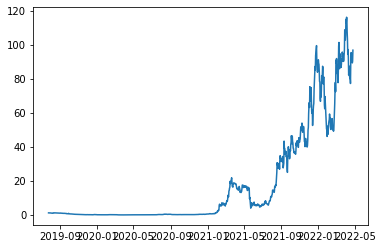

In [16]:
luna1['Date'] = pd.to_datetime(luna1.Date)
plt.plot(luna1.Date, luna1.Close )

### Preprocessing

In [9]:
# Add all ta features filling nans values
df = ta.add_all_ta_features(btc, "Open", "High", "Low", "Close", "Volume", fillna=True)

C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [10]:
bitcoindf = btc.copy()
bitcoindf = bitcoindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})

In [11]:
df = ta.add_all_ta_features(btc, "Open", "High", "Low", "Close", "Volume", fillna=True)

C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [12]:
bitcoindf['date'] = pd.to_datetime(bitcoindf.date)

Text(0.5, 1.0, 'Bitcoin Close Price')

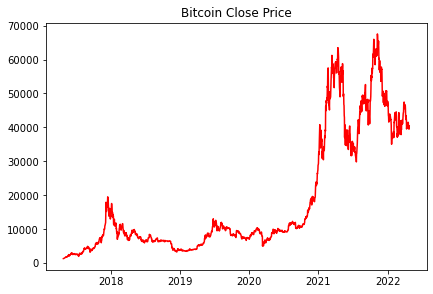

In [13]:
fig = plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(bitcoindf['date'], bitcoindf['close'], color="red")
plt.title('Bitcoin Close Price')

In [29]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

#  Bitcoin Close Price Prediction using XGBoost

#### Dataframe of bitcoin close price

In [106]:
curr = "btc"

In [87]:
closedf = bitcoindf[['date','close',"trend_macd"]]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1826, 3)


In [88]:
closedf = closedf[closedf['date'] > '2021-07-01']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  298


In [89]:
close_stock

,date,close,trend_macd
1528,2021-07-02,33897.046875,-1179.731055
1529,2021-07-03,34668.546875,-1071.556037
1530,2021-07-04,35287.781250,-925.194452
1531,2021-07-05,33746.003906,-922.970952
1532,2021-07-06,34235.195312,-871.686891
...,...,...,...
1821,2022-04-21,40527.363281,-716.261285
1822,2022-04-22,39740.320312,-779.936694
1823,2022-04-23,39486.730469,-841.166056
1824,2022-04-24,39469.292969,-880.942866


#### Separate data for Train and Test

In [90]:
training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data,test_data=closedf.iloc[0:training_size,:],closedf.iloc[training_size:len(closedf),:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (238, 3)
test_data:  (60, 3)


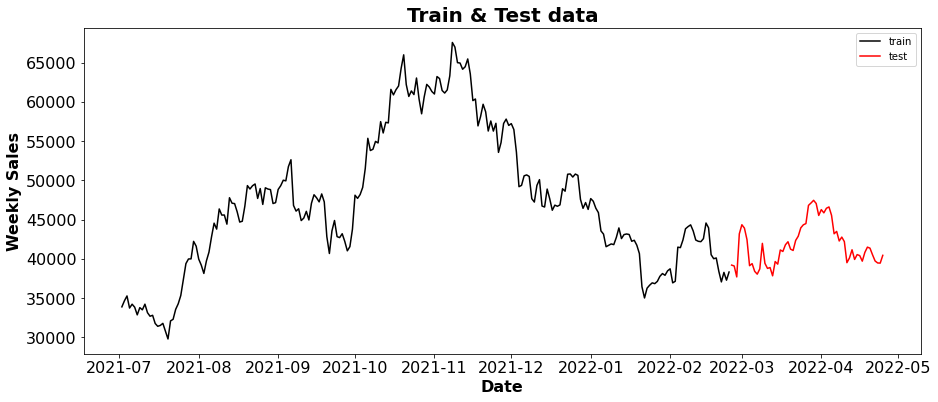

In [91]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['date'][:training_size], y = close_stock['close'][:training_size], color = 'black')
sns.lineplot(x = close_stock['date'][training_size:], y = close_stock['close'][training_size:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

#### Normalizing close price value

In [92]:
del train_data['date']
del test_data['date']
scaler = MinMaxScaler()
scaler_y = MinMaxScaler().fit(np.array(train_data['close']).reshape(-1,1)) 
scaler.fit(train_data)
X_train_scaled = pd.DataFrame(scaler.transform(train_data)) 
X_test_scaled = pd.DataFrame(scaler.transform(test_data))

In [114]:
X_test_scaled.iloc[-1,1:]

1    0.292753
Name: 59, dtype: float64

#### Prepare train data for time series analysis

In [95]:
time_step = 17
X_train, y_train = create_dataset(X_train_scaled, time_step)
X_test, y_test = create_dataset(X_test_scaled, time_step)


print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (220, 17)
y_train:  (220,)
X_test:  (42, 17)
y_test (42,)


In [96]:
#convert to dataframes
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

#append variables
X_train = pd.concat([X_train, X_train_scaled.iloc[time_step + 1:,1:].reset_index(drop=True)], axis = 1, ignore_index = True)
X_test = pd.concat([X_test, X_test_scaled.iloc[time_step + 1:,1:].reset_index(drop=True)], axis = 1, ignore_index = True)

#convert back to array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [99]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (220, 18)
y_train:  (220,)
X_test:  (42, 18)
y_test (42,)


#### Import XGBRegressor module and Fit X_train and y_train for training model

In [100]:
my_model2 = XGBRegressor(n_estimators=1000)
my_model2.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

#### Model testing and evaluation

In [101]:
#second run with "close", 17 days, two added variables
predictions = my_model2.predict(X_test)
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Root Mean squared Error - RMSE : 0.02775871674272101


In [135]:
#second run with "close", 17 days
predictions = my_model2.predict(X_test)
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Root Mean squared Error - RMSE : 0.02826373712271116


In [112]:
#second run with "close", 15 days
predictions = my_model2.predict(X_test)
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Root Mean squared Error - RMSE : 0.030854679339866742


In [63]:
#second run with "close", 10 days, july
predictions = my_model2.predict(X_test)
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Root Mean squared Error - RMSE : 0.03868122390703764


In [125]:
#second run with "close" and 15 days
predictions = my_model2.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.03600010983476512
Root Mean squared Error - RMSE : 0.04745400373034746


In [94]:
#second run with "close", "trend_macd", "volume"
predictions = my_model1.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.03600010983476512
Root Mean squared Error - RMSE : 0.04745400373034746


In [24]:
#first run - just with close data
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.03586139649678331
Root Mean squared Error - RMSE : 0.04974812278025246


In [102]:

train_predict=my_model2.predict(X_train)
test_predict=my_model2.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

# Transform back to original form
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
original_ytrain = scaler_y.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler_y.inverse_transform(y_test.reshape(-1,1)) 

Train data prediction: (220, 1)
Test data prediction: (42, 1)


In [103]:
# Transform back to original form
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
original_ytrain = scaler_y.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler_y.inverse_transform(y_test.reshape(-1,1)) 

In [107]:
#unscaled datasets
RMSE = str(math.sqrt(mean_squared_error(original_ytest, test_predict)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(original_ytest, test_predict))))

Root Mean squared Error - RMSE : 1048.1548257124612


In [105]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf[['close']])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf[['close']])
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


Train predicted data:  (298, 1)
Test predicted data:  (298, 1)


In [109]:
#Predicting tomorrow
tomorrow_scaled = my_model2.predict(X_test)[-1]
tomorrow = scaler_y.inverse_transform(tomorrow_scaled.reshape(-1,1)) 
tomorrow

array([[39026.05]], dtype=float32)

In [118]:
#Predicting day after tomorrow
appended_X_test_scaled = X_test_scaled.append([float(tomorrow_scaled)], ignore_index = True)
X_test_append, y_test_append = create_dataset(appended_X_test_scaled, time_step)

,0,1
0,0.249126,0.296772
1,0.246238,0.300556
2,0.209284,0.289762
3,0.354504,0.341264
4,0.385262,0.394746
...,...,...
56,0.263059,0.298552
57,0.256343,0.290340
58,0.255881,0.285005
59,0.282074,0.292753


In [124]:
X_test_append = pd.DataFrame(X_test_append)
X_test_append = pd.concat([X_test_append, X_test_scaled.iloc[time_step + 1:,1:].reset_index(drop=True)], axis = 1, ignore_index = True).fillna(method="ffill")

In [125]:
tomorrow_tomorrow_scaled = my_model2.predict(X_test_append)[-1]
tomorrow_tomorrow = scaler_y.inverse_transform(tomorrow_tomorrow_scaled.reshape(-1,1)) 
tomorrow_tomorrow

array([[39959.55]], dtype=float32)

In [128]:
output = [curr,RMSE, float(tomorrow), float(tomorrow_tomorrow) ]

#rename columns
pd.DataFrame(output).T

,0,1,2,3
0,btc,1048.1548257124612,39026.050781,39959.550781


In [27]:
curr = "btc"

def predict_coin(curr,df, date, time_step=17):
    df = df.copy()
    df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)
    df = df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
    df['date'] = pd.to_datetime(df.date)
    
    #create dataframe with needed features
    closedf = df[['date','close',"trend_macd"]]
    
    closedf = closedf[closedf['date'] > date]
    close_stock = closedf.copy()

    #set training size
    training_size=int(len(closedf)*0.80)
    test_size=len(closedf)-training_size
    train_data,test_data=closedf.iloc[0:training_size,:],closedf.iloc[training_size:len(closedf),:]
    
    #normalize price
    del train_data['date']
    del test_data['date']
    scaler = MinMaxScaler()
    scaler_y = MinMaxScaler().fit(np.array(train_data['close']).reshape(-1,1)) 
    scaler.fit(train_data)
    X_train_scaled = pd.DataFrame(scaler.transform(train_data)) 
    X_test_scaled = pd.DataFrame(scaler.transform(test_data))
    
    #create the looped datasets for "close"
    X_train, y_train = create_dataset(X_train_scaled, time_step)
    X_test, y_test = create_dataset(X_test_scaled, time_step)
    
    #convert to dataframes
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    #append variables
    X_train = pd.concat([X_train, X_train_scaled.iloc[time_step + 1:,1:].reset_index(drop=True)], axis = 1, ignore_index = True)
    X_test = pd.concat([X_test, X_test_scaled.iloc[time_step + 1:,1:].reset_index(drop=True)], axis = 1, ignore_index = True)

    #convert back to array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    #build model
    my_model2 = XGBRegressor(n_estimators=1000)
    my_model2.fit(X_train, y_train, verbose=True)
    
    #get predictions
    predictions = my_model2.predict(X_test)
    scaled_rmse = math.sqrt(mean_squared_error(y_test, predictions))
    
    train_predict=my_model2.predict(X_train)
    test_predict=my_model2.predict(X_test)

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)

    # Transform back to original form
    train_predict = scaler_y.inverse_transform(train_predict)
    test_predict = scaler_y.inverse_transform(test_predict)
    original_ytrain = scaler_y.inverse_transform(y_train.reshape(-1,1)) 
    original_ytest = scaler_y.inverse_transform(y_test.reshape(-1,1)) 
    
    #get unscaled rmse 
    RMSE = str(math.sqrt(mean_squared_error(original_ytest, test_predict)))
    
    #Predicting tomorrow
    tomorrow_scaled = my_model2.predict(X_test)[-1]
    tomorrow = scaler_y.inverse_transform(tomorrow_scaled.reshape(-1,1)) 
    
    #Predicting day after tomorrow
    appended_X_test_scaled = X_test_scaled.append([float(tomorrow_scaled)], ignore_index = True)
    X_test_append, y_test_append = create_dataset(appended_X_test_scaled, time_step)
    
    #adding tomorrows variables to dataframe 
    X_test_append = pd.DataFrame(X_test_append)
    X_test_append = pd.concat([X_test_append, X_test_scaled.iloc[time_step + 1:,1:].reset_index(drop=True)], axis = 1, ignore_index = True).fillna(method="ffill")
    
    #predicting day after tomorrow 
    tomorrow_tomorrow_scaled = my_model2.predict(X_test_append)[-1]
    tomorrow_tomorrow = scaler_y.inverse_transform(tomorrow_tomorrow_scaled.reshape(-1,1)) 
    
    #create output
    output = [curr,RMSE, float(tomorrow), float(tomorrow_tomorrow) ]
    return pd.DataFrame(output).T

In [32]:
ada_output = predict_coin("ada",ada,date='2021-07-01')
atom_output = predict_coin("atom",atom,date='2021-07-01')
avax_output = predict_coin("avax",avax,date='2021-07-01')
axs_output = predict_coin("axs",axs,date='2021-07-01')
btc_output = predict_coin("btc",btc,date='2021-07-01')
eth_output = predict_coin("eth",eth,date='2021-02-01')
link_output = predict_coin("link",link,date='2021-07-01')
luna1_output = predict_coin("luna1",luna1,date='2021-05-01')
matic_output = predict_coin("matic",matic,date='2021-07-01')
sol_output = predict_coin("sol",sol,date='2021-07-01')

C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\mdurh\a

In [33]:
final = pd.concat([ada_output, atom_output, avax_output, axs_output, btc_output, eth_output, link_output,
        luna1_output, matic_output, sol_output], axis=0)
final.columns = ["Currency", "RMSE","Tomorrow","Tomorrow+1"]
final

,Currency,RMSE,Tomorrow,Tomorrow+1
0,ada,0.06938530571025403,0.910327,0.910327
0,atom,2.1713252908137455,21.980719,21.551289
0,avax,5.2213154842955625,71.17643,71.17643
0,axs,5.776248206855418,56.342484,55.716213
0,btc,1048.1548257124612,39026.050781,39959.550781
0,eth,130.52684366653097,2870.135254,2865.402344
0,link,0.8681123785785104,14.506732,14.440706
0,luna1,20.364699475131307,72.640503,75.514297
0,matic,0.07870155168865467,1.259168,1.276718
0,sol,6.856162867759423,109.433052,103.558243


In [34]:
final.to_csv('XGB.csv')

Text(0.5, 1.0, 'Bitcoin Close Price')

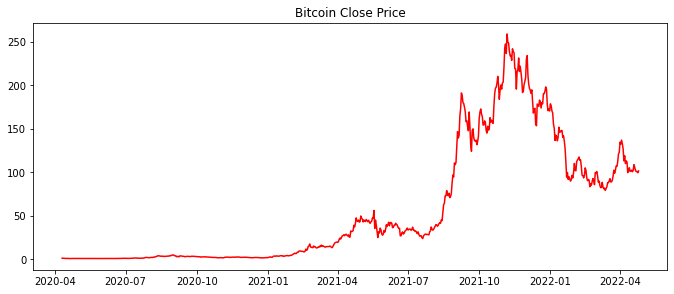

In [25]:
sol['Date'] = pd.to_datetime(sol.Date)
fig = plt.figure(figsize = (25,10))

plt.subplot(2, 2, 1)
plt.plot(sol['Date'], sol['Close'], color="red")
plt.title('Bitcoin Close Price')